In [ ]:
# - 객체 인식 및 마스크 생성

# PixelLib 라이브러리의 PascalVOC 모델을 사용해 사람/강아지 영역을 자동으로 인식하고 마스크 생성


# - 마스크 정제 기법

# 침식(Erosion) 작업으로 작은 잡음 제거
# 팽창(Dilation)으로 객체 형태 복원
# 가우시안 블러로 마스크 경계 부드럽게 처리


# - 합성 기법

# 하드 컴포지팅: 이진 마스크 기반 직접 합성
# 소프트 블렌딩: 알파 채널 기반 페더링(feathering) 적용으로 경계 자연스럽게 처리


# - 배경 처리 효과

# 배경 블러 효과로 인물/동물 강조
# 완전히 새로운 배경으로 교체 가능

In [60]:
# <발견했던 문제들>

# mask 경계가 거칠거나 왜곡되어 있으며, 부분적으로 옷 테두리/손/머리카락 등이 잘리거나 남는 문제 존재

# Morphology 없이 mask만 적용했을 때의 문제
# 침식 없이 바로 dilation하거나, blur 없이 바로 합성할 경우 경계가 부자연스러움

# Soft blending에서도 발생 가능한 단점 
# feathering 기법은 경계가 부드러워지지만, 너무 강하게 적용할 경우 경계가 흐릿해져 객체 경계가 애매해질 수 있음

# -----------------------------------------------------------------------

# <시도했던 방법들>

# Morphological operation 도입 (침식 + 팽창)
# 작은 노이즈 제거 후 경계 복원이라는 논리적 흐름으로, mask 품질 향상

# Gaussian Blur로 soft transition 구현
# 경계선을 부드럽게 처리해 시각적으로 자연스럽고 실제 사진처럼 보이도록 개선

# Feathered Alpha Blending 적용 (Soft Blending 방식)
# 단순 binary mask 합성이 아닌 알파 블렌딩 기반 soft 합성을 제안함으로써, 객체-배경 경계가 더 매끄럽게 처리됨

In [1]:
import os
from IPython.display import display
from ipywidgets import FileUpload, Button, Output
from PIL import Image
from io import BytesIO

# 저장 디렉토리
save_dir = 'uploaded_images'
os.makedirs(save_dir, exist_ok=True)

# 업로드 위젯
uploader = FileUpload(
    accept='.jpg,.png',
    multiple=True,
    description='이미지 업로드'
)

# 저장 버튼
save_btn = Button(description='저장하기')
out = Output()

def on_save_clicked(b):
    with out:
        if not uploader.value:
            print("⚠️ 업로드된 파일이 없습니다.")
            return
        for filename, fileinfo in uploader.value.items():
            # fileinfo['content'] 에 raw bytes
            file_path = os.path.join(save_dir, filename)
            with open(file_path, 'wb') as f:
                f.write(fileinfo['content'])
            print(f"✅ 저장됨: {file_path}")
        # 업로드 메모리 초기화 (필요시)
        uploader.value.clear()
        uploader._counter = 0

save_btn.on_click(on_save_clicked)

display(uploader, save_btn, out)

FileUpload(value={}, accept='.jpg,.png', description='이미지 업로드', multiple=True)

Button(description='저장하기', style=ButtonStyle())

Output()

In [6]:
import os

# 저장 경로 지정
save_dir = os.path.expanduser('~/aiffel/human_segmentation/images')
os.makedirs(save_dir, exist_ok=True)

# 업로드된 파일 저장
for filename, fileinfo in uploader.value.items():
    with open(os.path.join(save_dir, filename), 'wb') as f:
        f.write(fileinfo['content'])

print("✅ 업로드 및 저장 완료!")

✅ 업로드 및 저장 완료!


In [9]:
# 저장
for filename, fileinfo in uploader.value.items():
    with open(os.path.join(save_dir, filename), 'wb') as f:
        f.write(fileinfo['content'])

print("✅ 새 이미지 업로드 완료!")

✅ 새 이미지 업로드 완료!


In [10]:
print("📂 저장된 이미지 파일 목록:")
print(os.listdir(save_dir))

📂 저장된 이미지 파일 목록:
['your_background_image.jpg', 'your_chromakey_image.png', 'my_image.png', 'cha_image.jpg', 'dog_tired.png']


✅ 이미지 크기: (730, 730, 3)


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 128444 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 49352 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 47196 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 50629 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 46300 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 54620 missing from current font.
  font.set

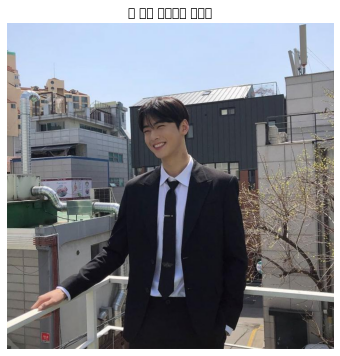

In [13]:
import os
import cv2
import matplotlib.pyplot as plt

# 저장 경로
save_dir = os.path.expanduser('~/aiffel/human_segmentation/images')

# 불러올 파일명
img_filename = 'cha_image.jpg'
img_path = os.path.join(save_dir, img_filename)

# 이미지 읽기
img_orig = cv2.imread(img_path)

# 결과 확인
if img_orig is None:
    print("❌ 이미지를 불러오지 못했습니다. 경로를 다시 확인해 주세요:")
    print(f"   기대 경로: {img_path}")
    print(f"   실제 디렉토리 목록: {os.listdir(save_dir)}")
else:
    print(f"✅ 이미지 크기: {img_orig.shape}")  # (높이, 너비, 채널)
    plt.figure(figsize=(10, 6))
    # OpenCV는 BGR 포맷이므로 RGB로 변환
    plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
    plt.title("🖼️ 새로 업로드한 이미지")
    plt.axis("off")
    plt.show()

In [14]:
from pixellib.semantic import semantic_segmentation
import urllib.request

# 모델 저장 폴더 및 경로 설정
model_dir = os.path.join(os.path.expanduser('~/aiffel/human_segmentation/models'))
os.makedirs(model_dir, exist_ok=True)

model_path = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# 모델 다운로드
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

print("📥 모델 다운로드 중...")
urllib.request.urlretrieve(model_url, model_path)
print("✅ 모델 다운로드 완료!")

📥 모델 다운로드 중...
✅ 모델 다운로드 완료!


In [15]:
# 세그멘테이션 모델 생성 및 로드
model = semantic_segmentation()
model.load_pascalvoc_model(model_path)

# 이미지 세그멘테이션 실행
segvalues, output = model.segmentAsPascalvoc(img_path)

/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 127912 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 49464 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 47704 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 53580 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51060 missing from current font.
  font.set

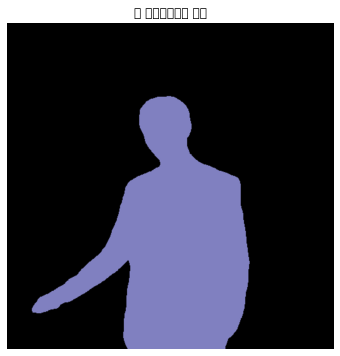

🧠 감지된 객체들:
- background
- person


In [16]:
# 결과 시각화
plt.figure(figsize=(10, 6))
plt.imshow(output)
plt.title("🎨 세그멘테이션 결과")
plt.axis("off")
plt.show()

# 어떤 객체들이 검출됐는지 확인
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

print("🧠 감지된 객체들:")
for class_id in segvalues['class_ids']:
    print(f"- {LABEL_NAMES[class_id]}")

/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 129485 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 46988 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 50689 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 50669 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 47560 missing from current font.
  font.set

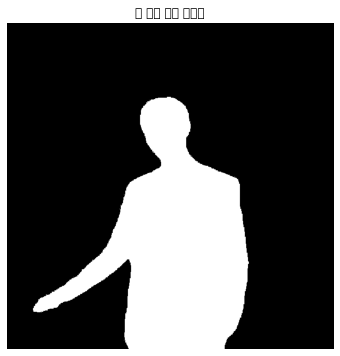

📐 마스크 shape: (730, 730)


In [17]:
import numpy as np

# RGB → BGR 순서로 변경 (PixelLib 결과 이미지의 색상 순서와 맞추기 위해)
seg_color = (128, 128, 192)  # colormap[15]의 BGR

# output에서 사람 색상만 골라내기
seg_map = np.all(output == seg_color, axis=-1)

# 마스크 시각화
plt.figure(figsize=(8, 6))
plt.imshow(seg_map, cmap='gray')
plt.title("🧍 사람 영역 마스크")
plt.axis("off")
plt.show()

print("📐 마스크 shape:", seg_map.shape)

/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 128248 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51064 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 47932 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 47784 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 46300 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 50756 missing from current font.
  font.set

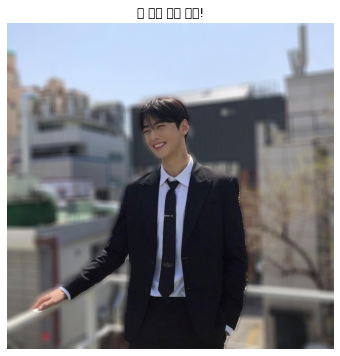

In [18]:
# 1채널 마스크 → 3채널로 변환
img_mask = seg_map.astype(np.uint8) * 255
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# 배경만 마스킹하기 위해 반전
img_bg_mask = cv2.bitwise_not(img_mask_color)

# 원본 이미지 블러 처리
img_blur = cv2.blur(img_orig, (15, 15))

# 배경 부분만 blur 이미지로 만들기
img_bg_blur = cv2.bitwise_and(img_blur, img_bg_mask)

# 사람 부분만 원본 유지
img_fg = cv2.bitwise_and(img_orig, img_mask_color)

# 두 이미지 합성
img_concat = cv2.add(img_bg_blur, img_fg)

# 결과 시각화
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.title("📸 인물 모드 완성!")
plt.axis("off")
plt.show()

In [19]:
# ✅ STEP 1: 기존 마스크 불러오기 (이미 있다면 생략)
img_mask = seg_map.astype(np.uint8) * 255  # binary mask (0, 255)

In [20]:
# ✅ STEP 2: Morphological Operation 적용
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))  # 커널 사이즈 조정 가능

# 1. erosion (침식) → 너무 넓은 영역을 줄임 (작은 잡음 제거)
img_mask_eroded = cv2.erode(img_mask, kernel, iterations=1)

# 2. dilation (팽창) → 모양 복원 (경계 부드럽게)
img_mask_refined = cv2.dilate(img_mask_eroded, kernel, iterations=1)

In [21]:
# ✅ STEP 3: Optional - Gaussian Blur로 부드러운 가장자리 만들기
img_mask_blurred = cv2.GaussianBlur(img_mask_refined, (7, 7), 0)

In [22]:
# ✅ STEP 4: 3채널 마스크로 변환
img_mask_color = cv2.cvtColor(img_mask_blurred, cv2.COLOR_GRAY2BGR)

In [23]:
# ✅ STEP 5: 배경 마스크 반전
img_bg_mask = cv2.bitwise_not(img_mask_color)

In [24]:
# ✅ STEP 6: 원본 이미지에서 배경을 블러링
img_blur = cv2.blur(img_orig, (15, 15))  # 커널 크기 조절 가능
img_bg_blur = cv2.bitwise_and(img_blur, img_bg_mask)

In [25]:
# ✅ STEP 7: 사람 부분은 원본 그대로 사용
img_fg = cv2.bitwise_and(img_orig, img_mask_color)

In [26]:
# ✅ STEP 8: 합성 (foreground + blurred background)
img_concat = cv2.add(img_bg_blur, img_fg)

/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 10024 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 49440 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 46108 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 50857 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 10024 missing from current font.
  font.set_

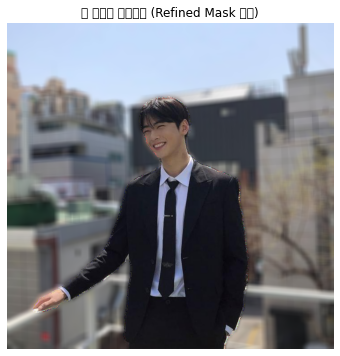

In [27]:
# ✅ STEP 9: 결과 출력
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.title("✨ 개선된 인물모드 (Refined Mask 사용)")
plt.axis("off")
plt.show()

# Refined Mask + Hard Composite
# 경계 잡음(스팟 노이즈)을 침식·팽창으로 제거해 깔끔한 마스크 생성
# 마스크 경계가 여전히 “딱 끊긴” 느낌(하드 엣지)
# 복잡한 배경과 대상이 섞여 있을 때 부자연스러운 합성 자국 발생 가능

In [28]:
# STEP 1: 마스크 float 변환 + 정규화 (0~1)
alpha_mask = img_mask_blurred.astype(np.float32) / 255.0
alpha_mask_color = cv2.merge([alpha_mask] * 3)

In [29]:
# STEP 2: 이미지 float 변환
img_orig_f = img_orig.astype(np.float32)
img_blur_f = img_blur.astype(np.float32)

In [30]:
# STEP 3: Soft blend (alpha_mask를 기준으로 선형 혼합)
img_soft_blend = (img_orig_f * alpha_mask_color) + (img_blur_f * (1 - alpha_mask_color))
img_soft_blend = img_soft_blend.astype(np.uint8)

/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 127752 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 48512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 47084 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 50868 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 46160 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 47532 missing from current font.
  font.set

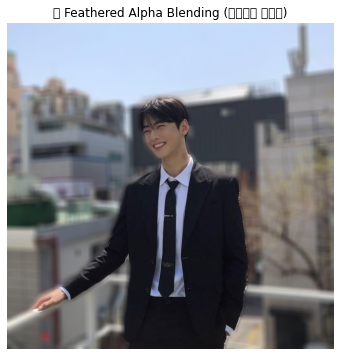

In [31]:
# STEP 4: 결과 시각화
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img_soft_blend, cv2.COLOR_BGR2RGB))
plt.title("🌈 Feathered Alpha Blending (부드러운 테두리)")
plt.axis("off")
plt.show()

# 마스크 경계가 자연스럽게 페더링되어, 배경과 전경의 이음새가 부드러움
# 복잡한 경계(털, 깃털 등)에도 어울림
# 픽셀 단위 float 연산이 추가되어 연산량 증가
# 지나치게 넓은 페더링은 대상이 배경에 묻히는 듯한 인상 줄 수 있음

/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 127749 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 49352 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 48176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 54633 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 127749 missing from current font.
  font.se

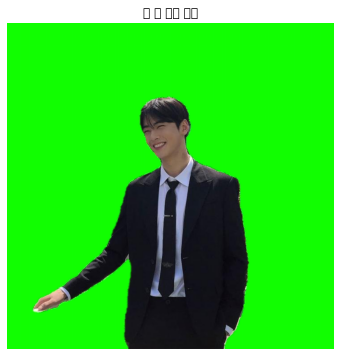

In [34]:
# 배경만 있는 이미지 불러오기
bg_path = os.path.join(save_dir, 'your_chromakey_image.png')
bg_image = cv2.imread(bg_path)
bg_image = cv2.resize(bg_image, (img_orig.shape[1], img_orig.shape[0]))  # 크기 맞춤

# 배경 = 기존 이미지 마스크 반전
img_bg_mask = cv2.bitwise_not(img_mask_color)

# 새 배경과 합성
person_fg = cv2.bitwise_and(img_orig, img_mask_color)
bg_only = cv2.bitwise_and(bg_image, img_bg_mask)
img_replaced = cv2.add(person_fg, bg_only)

plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img_replaced, cv2.COLOR_BGR2RGB))
plt.title("🌅 새 배경 합성")
plt.axis("off")
plt.show()

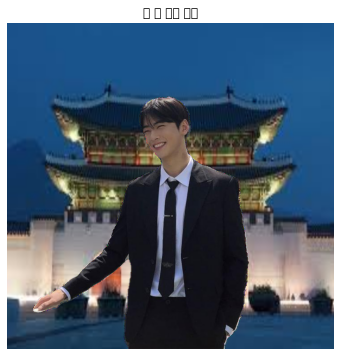

In [35]:
# 배경만 있는 이미지 불러오기
bg_path = os.path.join(save_dir, 'your_background_image.jpg')
bg_image = cv2.imread(bg_path)
bg_image = cv2.resize(bg_image, (img_orig.shape[1], img_orig.shape[0]))  # 크기 맞춤

# 배경 = 기존 이미지 마스크 반전
img_bg_mask = cv2.bitwise_not(img_mask_color)

# 새 배경과 합성
person_fg = cv2.bitwise_and(img_orig, img_mask_color)
bg_only = cv2.bitwise_and(bg_image, img_bg_mask)
img_replaced = cv2.add(person_fg, bg_only)

plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img_replaced, cv2.COLOR_BGR2RGB))
plt.title("🌅 새 배경 합성")
plt.axis("off")
plt.show()

✅ 이미지 크기: (550, 422, 3)


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 128444 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 47196 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 50629 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 54620 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 48120 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51648 missing from current font.
  font.set

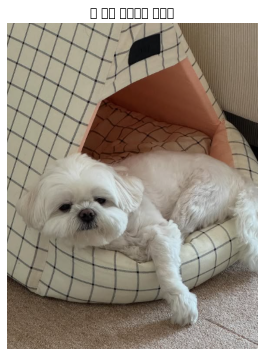

In [37]:
import os
import cv2
import matplotlib.pyplot as plt

# 저장 경로
save_dir = os.path.expanduser('~/aiffel/human_segmentation/images')

# 불러올 파일명
img_filename = 'dog_tired.png'
img_path = os.path.join(save_dir, img_filename)

# 이미지 읽기
img_orig = cv2.imread(img_path)

# 결과 확인
if img_orig is None:
    print("❌ 이미지를 불러오지 못했습니다. 경로를 다시 확인해 주세요:")
    print(f"   기대 경로: {img_path}")
    print(f"   실제 디렉토리 목록: {os.listdir(save_dir)}")
else:
    print(f"✅ 이미지 크기: {img_orig.shape}")  # (높이, 너비, 채널)
    plt.figure(figsize=(10, 6))
    # OpenCV는 BGR 포맷이므로 RGB로 변환
    plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
    plt.title("🖼️ 새로 업로드한 이미지")
    plt.axis("off")
    plt.show()

In [38]:
# 세그멘테이션 모델 생성 및 로드
model = semantic_segmentation()
model.load_pascalvoc_model(model_path)

# 이미지 세그멘테이션 실행
segvalues, output = model.segmentAsPascalvoc(img_path)

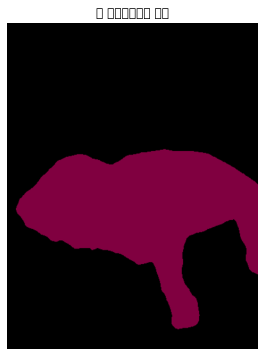

🧠 감지된 객체들:
- background
- dog


In [48]:
# 결과 시각화
plt.figure(figsize=(10, 6))
plt.imshow(output)
plt.title("🎨 세그멘테이션 결과")
plt.axis("off")
plt.show()

# 어떤 객체들이 검출됐는지 확인
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

print("🧠 감지된 객체들:")
for class_id in segvalues['class_ids']:
    print(f"- {LABEL_NAMES[class_id]}")

/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 128054 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 50500 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 128054 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 50500 missing from current font.
  font.set_te

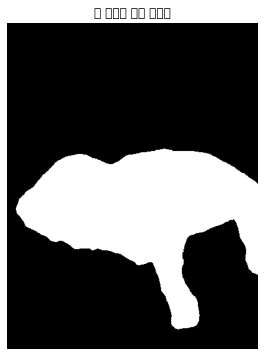

📐 마스크 shape: (550, 422)


In [52]:
dog_mask = segvalues['masks']  # shape: (550, 422), dtype: bool

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.imshow(dog_mask, cmap='gray')
plt.title("🐶 강아지 영역 마스크")
plt.axis("off")
plt.show()

print("📐 마스크 shape:", dog_mask.shape)

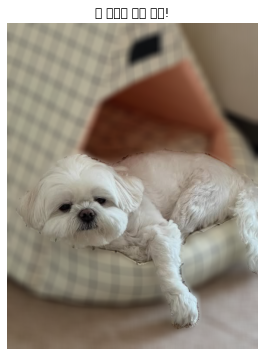

In [53]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# img_orig: 이전에 불러온 원본 이미지 (BGR 포맷)
# dog_mask: segvalues['masks'] 전체 배열, shape=(H, W), dtype=bool

# 1) Boolean 마스크 → uint8 1채널 마스크 (0 또는 255)
img_mask = dog_mask.astype(np.uint8) * 255  # shape=(H, W), 값은 0 또는 255

# 2) 1채널 → 3채널 BGR 마스크
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)  # shape=(H, W, 3)

# 3) 배경 마스크 (강아지가 아닌 부분) — 반전
img_bg_mask = cv2.bitwise_not(img_mask_color)

# 4) 원본 이미지 블러 처리
img_blur = cv2.blur(img_orig, (15, 15))

# 5) 배경 부분만 블러 이미지로
img_bg_blur = cv2.bitwise_and(img_blur, img_bg_mask)

# 6) 강아지(전경) 부분만 원본 이미지로
img_fg = cv2.bitwise_and(img_orig, img_mask_color)

# 7) 블러된 배경 + 선명한 전경 합성
img_concat = cv2.add(img_bg_blur, img_fg)

# 8) 결과 시각화 (Matplotlib은 RGB 포맷)
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.title("📸 강아지 모드 완성!")
plt.axis("off")
plt.show()

/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 127775 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 127775 missing from current font.
  font.set_text(s, 0, flags=flags)


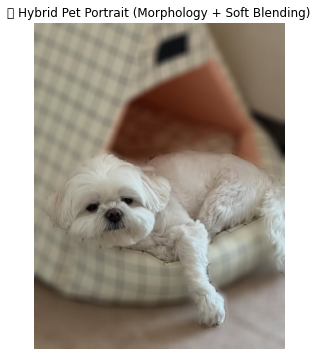

In [54]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ————————————————————————————————
# 준비: img_orig (BGR), dog_mask (bool mask H×W)
# ————————————————————————————————

# 1) Binary mask → uint8 → Morphology refine
img_mask = dog_mask.astype(np.uint8) * 255
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
mask_eroded = cv2.erode(img_mask, kernel, iterations=1)
mask_refined = cv2.dilate(mask_eroded, kernel, iterations=1)

# 2) Soft edge: Gaussian blur → normalize to [0,1]
mask_blur = cv2.GaussianBlur(mask_refined, (7, 7), 0)
alpha = mask_blur.astype(np.float32) / 255.0  # shape (H, W), float32

# 3) Prepare float images
img_orig_f = img_orig.astype(np.float32)
img_blur = cv2.blur(img_orig, (15, 15))
img_blur_f = img_blur.astype(np.float32)

# 4) Soft alpha blending
#    expand alpha to 3 channels
alpha_3 = cv2.merge([alpha, alpha, alpha])
img_hybrid = img_orig_f * alpha_3 + img_blur_f * (1 - alpha_3)
img_hybrid = np.clip(img_hybrid, 0, 255).astype(np.uint8)

# 5) 시각화
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img_hybrid, cv2.COLOR_BGR2RGB))
plt.title("🌟 Hybrid Pet Portrait (Morphology + Soft Blending)")
plt.axis("off")
plt.show()

# 앞에서 차은우 이미지에 적용한 방법 2가지 모두 적용
# 1) Morphology(erosion→dilation) + Gaussian blur로 깔끔하고 부드러운 마스크 생성
# 2) Soft alpha blending으로 자연스러운 경계 처리
# 하드 컴포지트의 깔끔함과 소프트 블렌딩의 자연스러움을 모두 취함

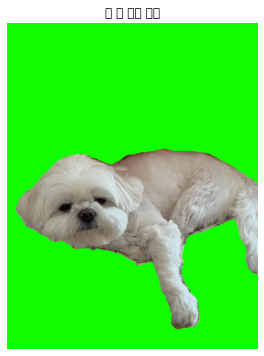

In [55]:
# 배경만 있는 이미지 불러오기
bg_path = os.path.join(save_dir, 'your_chromakey_image.png')
bg_image = cv2.imread(bg_path)
bg_image = cv2.resize(bg_image, (img_orig.shape[1], img_orig.shape[0]))  # 크기 맞춤

# 배경 = 기존 이미지 마스크 반전
img_bg_mask = cv2.bitwise_not(img_mask_color)

# 새 배경과 합성
person_fg = cv2.bitwise_and(img_orig, img_mask_color)
bg_only = cv2.bitwise_and(bg_image, img_bg_mask)
img_replaced = cv2.add(person_fg, bg_only)

plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img_replaced, cv2.COLOR_BGR2RGB))
plt.title("🌅 새 배경 합성")
plt.axis("off")
plt.show()

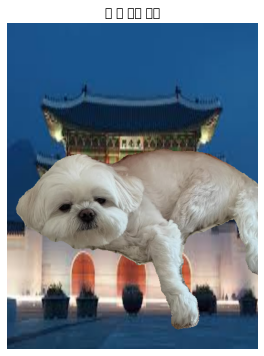

In [57]:
# 배경만 있는 이미지 불러오기
bg_path = os.path.join(save_dir, 'your_background_image.jpg')
bg_image = cv2.imread(bg_path)
bg_image = cv2.resize(bg_image, (img_orig.shape[1], img_orig.shape[0]))  # 크기 맞춤

# 배경 = 기존 이미지 마스크 반전
img_bg_mask = cv2.bitwise_not(img_mask_color)

# 새 배경과 합성
person_fg = cv2.bitwise_and(img_orig, img_mask_color)
bg_only = cv2.bitwise_and(bg_image, img_bg_mask)
img_replaced = cv2.add(person_fg, bg_only)

plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img_replaced, cv2.COLOR_BGR2RGB))
plt.title("🌅 새 배경 합성")
plt.axis("off")
plt.show()